In [5]:
import tensorflow as tf

In [6]:
import pandas as pd

In [7]:
print("hello")

hello


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os

# Path to the train.parquet directory
data_dir = "/Users/abdur-rahmanibn-bilalwaajid/jane_street_project/data/train.parquet"
partitions = ["partition_id=0", "partition_id=1"]  # Select manageable partitions

# Function to load and preprocess a single partition
def load_and_preprocess_partition(partition_path):
    file_path = os.path.join(data_dir, partition_path)
    df = pd.read_parquet(file_path, engine="pyarrow", columns=[f"feature_{i:02d}" for i in range(20)] + ["responder_6"])
    df.fillna(0, inplace=True)  # Handle missing values
    return df

# Initialize a list to collect data
data_frames = []

# Load data from selected partitions
for partition in partitions:
    print(f"Loading data from: {partition}")
    df_partition = load_and_preprocess_partition(partition)
    data_frames.append(df_partition)

# Combine all loaded data into one DataFrame
data = pd.concat(data_frames, ignore_index=True)

# Split features and target
X = data[[f"feature_{i:02d}" for i in range(20)]].values
y = data["responder_6"].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Clear memory of intermediate data
del data, data_frames, df_partition

# Define the MLP model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # Use fewer epochs for faster training
    batch_size=32,
    verbose=1
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Loading data from: partition_id=0
Loading data from: partition_id=1
Epoch 1/10


2024-12-25 23:21:33.036275: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


118712/118712 [==============================] - 78s 654us/step - loss: 0.7834 - mae: 0.5839 - val_loss: 0.7825 - val_mae: 0.5832
Epoch 2/10
118712/118712 [==============================] - 74s 621us/step - loss: 0.7817 - mae: 0.5833 - val_loss: 0.7821 - val_mae: 0.5833
Epoch 3/10
118712/118712 [==============================] - 73s 616us/step - loss: 0.7813 - mae: 0.5832 - val_loss: 0.7818 - val_mae: 0.5832
Epoch 4/10
118712/118712 [==============================] - 73s 615us/step - loss: 0.7811 - mae: 0.5831 - val_loss: 0.7814 - val_mae: 0.5838
Epoch 5/10
118712/118712 [==============================] - 73s 618us/step - loss: 0.7809 - mae: 0.5831 - val_loss: 0.7812 - val_mae: 0.5832
Epoch 6/10
118712/118712 [==============================] - 74s 622us/step - loss: 0.7808 - mae: 0.5831 - val_loss: 0.7816 - val_mae: 0.5828
Epoch 7/10
118712/118712 [==============================] - 74s 626us/step - loss: 0.7806 - mae: 0.5831 - val_loss: 0.7815 - val_mae: 0.5830
Epoch 8/10
118712/118712

In [9]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# File paths
features_file = "/Users/abdur-rahmanibn-bilalwaajid/jane_street_project/data/features.csv"  # File with feature tags

# Load features.csv
features_df = pd.read_csv(features_file)

# Preview the features.csv structure
print(features_df.head())

# Step 1: Identify Features by Tags
# Group features by their tags (e.g., tag_0, tag_1, etc.)
tags = [col for col in features_df.columns if "tag" in col]
features_by_tag = {}
for tag in tags:
    features_by_tag[tag] = features_df[features_df[tag] == True]['feature'].tolist()

# Print feature groups for exploration
for tag, features in features_by_tag.items():
    print(f"{tag}: {len(features)} features")

# Step 2: Load Data
# Let's load a small subset of data for these features
selected_features = features_by_tag['tag_0']  # Example: Features under tag_0
selected_features.append("responder_6")  # Add the target variable
data_path = "/Users/abdur-rahmanibn-bilalwaajid/jane_street_project/data/train.parquet/partition_id=0"

# Load data for selected features
df = pd.read_parquet(data_path, engine="pyarrow", columns=selected_features).head(50000)
print(f"Loaded data shape: {df.shape}")

# Step 3: Handle Missing Values
df.fillna(0, inplace=True)  # Replace missing values with 0 for simplicity

# Split features and target
X = df.drop(columns=["responder_6"]).values
y = df["responder_6"].values

# Step 4: Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Dimensionality Reduction using PCA
# Keep enough components to explain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original feature count: {X.shape[1]}")
print(f"Reduced feature count: {X_pca.shape[1]}")

# Optional: Save PCA-transformed data
pca_data = pd.DataFrame(X_pca, columns=[f"PC_{i+1}" for i in range(X_pca.shape[1])])
pca_data["responder_6"] = y
pca_data.to_csv( "/Users/abdur-rahmanibn-bilalwaajid/jane_street_project/data/pca_transformed_data.csv", index=False)

print("Feature engineering completed successfully.")

      feature  tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  \
0  feature_00  False  False   True  False  False  False  False  False  False   
1  feature_01  False  False   True  False  False  False  False  False  False   
2  feature_02  False  False   True  False  False  False  False  False  False   
3  feature_03  False  False   True  False  False  False  False  False  False   
4  feature_04  False  False   True  False  False  False  False  False  False   

   tag_9  tag_10  tag_11  tag_12  tag_13  tag_14  tag_15  tag_16  
0  False   False   False   False   False    True   False    True  
1  False   False   False   False    True    True   False    True  
2  False   False   False    True   False   False   False    True  
3  False   False   False   False    True   False   False    True  
4  False   False   False    True    True   False   False    True  
tag_0: 12 features
tag_1: 3 features
tag_2: 10 features
tag_3: 28 features
tag_4: 10 features
tag_5: 10 features
tag_

In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# File paths
features_file = "/Users/abdur-rahmanibn-bilalwaajid/jane_street_project/data/features.csv"
data_dir = "/Users/abdur-rahmanibn-bilalwaajid/jane_street_project/data/train.parquet"

# Load features.csv
features_df = pd.read_csv(features_file)

# Group features by tags
tags = [col for col in features_df.columns if "tag" in col]
features_by_tag = {tag: features_df[features_df[tag] == True]['feature'].tolist() for tag in tags}

# Select features from desired tags (e.g., tag_0 and tag_1)
selected_tags = ["tag_0", "tag_1", "tag_2"]  # Adjust based on analysis
selected_features = []
for tag in selected_tags:
    selected_features.extend(features_by_tag[tag])
selected_features.append("responder_6")  # Include the target variable

# Load a subset of data for these features
data_path = f"{data_dir}/partition_id=0"  # Use a single partition initially
df = pd.read_parquet(data_path, engine="pyarrow", columns=selected_features).head(50000)
print(f"Loaded data shape: {df.shape}")

# Handle missing values
df.fillna(0, inplace=True)

# Split features and target
X = df.drop(columns=["responder_6"]).values
y = df["responder_6"].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction (retain 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original feature count: {X.shape[1]}, Reduced feature count: {X_pca.shape[1]}")

Loaded data shape: (50000, 26)
Original feature count: 25, Reduced feature count: 11


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define an improved MLP model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,  # Adjust epochs based on your system's capacity
    batch_size=64,  # Adjust batch size for memory efficiency
    verbose=1
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/15
625/625 [==============================] - 1s 1ms/step - loss: 0.6564 - mae: 0.5576 - val_loss: 0.6039 - val_mae: 0.5362
Epoch 2/15
625/625 [==============================] - 1s 1ms/step - loss: 0.6452 - mae: 0.5509 - val_loss: 0.6004 - val_mae: 0.5360
Epoch 3/15
625/625 [==============================] - 1s 919us/step - loss: 0.6404 - mae: 0.5495 - val_loss: 0.5938 - val_mae: 0.5330
Epoch 4/15
625/625 [==============================] - 1s 919us/step - loss: 0.6376 - mae: 0.5483 - val_loss: 0.5932 - val_mae: 0.5327
Epoch 5/15
625/625 [==============================] - 1s 921us/step - loss: 0.6342 - mae: 0.5473 - val_loss: 0.5899 - val_mae: 0.5319
Epoch 6/15
625/625 [==============================] - 1s 999us/step - loss: 0.6316 - mae: 0.5464 - val_loss: 0.5887 - val_mae: 0.5307
Epoch 7/15
625/625 [==============================] - 1s 993us/step - loss: 0.6267 - mae: 0.5455 - val_loss: 0.5849 - val_mae: 0.5312
Epoch 8/15
625/625 [==============================] - 1s 1ms/step 

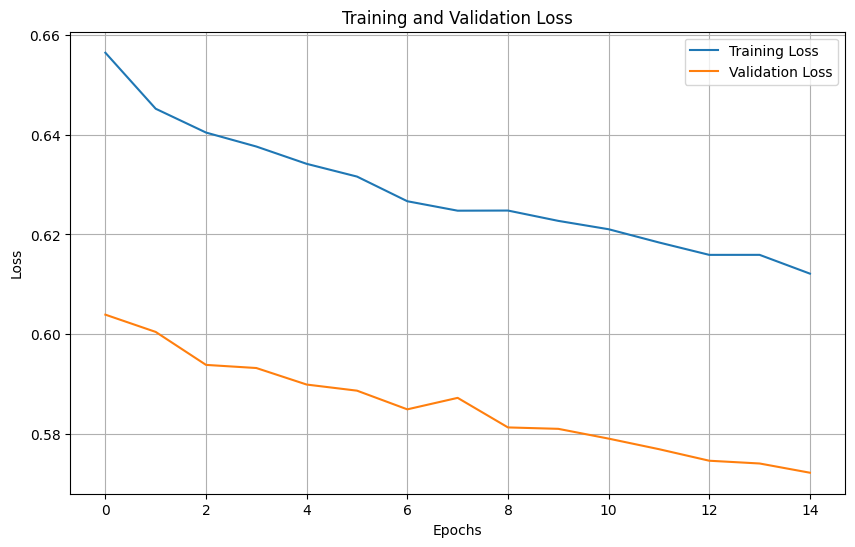

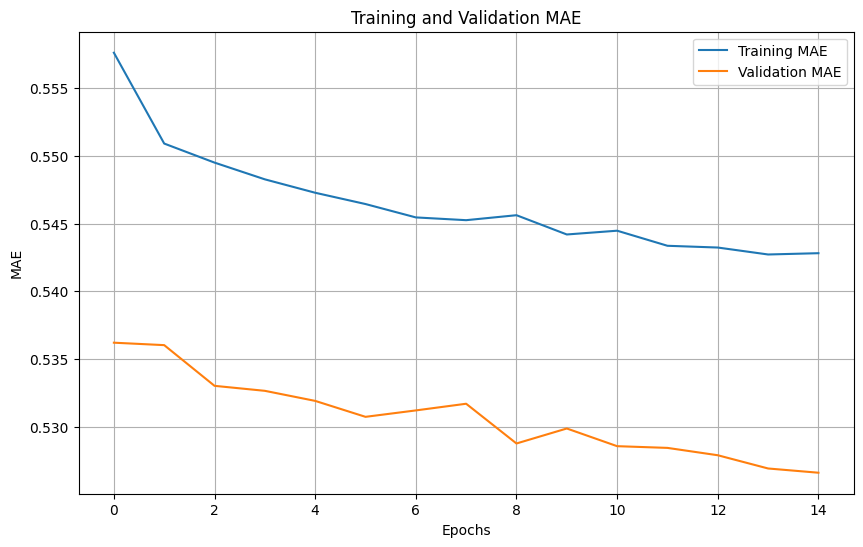

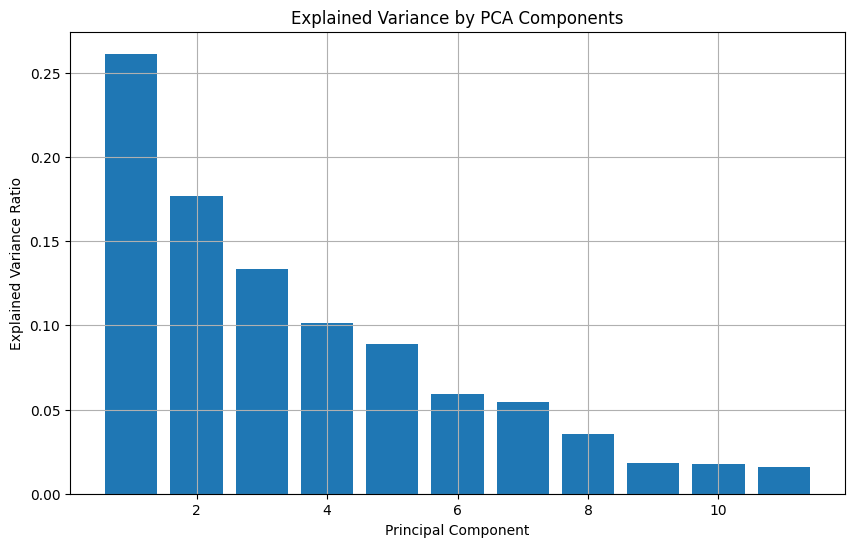

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Visualize feature importance using PCA explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.title('Explained Variance by PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

In [13]:
# Generate lagged features for selected columns
# Verify that all columns exist in the DataFrame
missing_features = [f"feature_{i:02d}" for i in range(20) if f"feature_{i:02d}" not in df.columns]
if missing_features:
    print(f"Missing columns: {missing_features}")
else:
    print("All features are available.")

Missing columns: ['feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19']


In [14]:
def create_lagged_features(df, columns, lags):
    for col in columns:
        if col in df.columns:  # Check if the column exists
            for lag in range(1, lags + 1):
                df[f"{col}_lag{lag}"] = df[col].shift(lag)
        else:
            print(f"Column {col} is missing. Skipping lagged feature creation.")
    return df

# Call the function after checking available columns
df = create_lagged_features(df, [f"feature_{i:02d}" for i in range(20)], lags=3)

Column feature_05 is missing. Skipping lagged feature creation.
Column feature_06 is missing. Skipping lagged feature creation.
Column feature_07 is missing. Skipping lagged feature creation.
Column feature_08 is missing. Skipping lagged feature creation.
Column feature_12 is missing. Skipping lagged feature creation.
Column feature_13 is missing. Skipping lagged feature creation.
Column feature_14 is missing. Skipping lagged feature creation.
Column feature_15 is missing. Skipping lagged feature creation.
Column feature_16 is missing. Skipping lagged feature creation.
Column feature_17 is missing. Skipping lagged feature creation.
Column feature_18 is missing. Skipping lagged feature creation.
Column feature_19 is missing. Skipping lagged feature creation.


In [15]:
print(df.head())
print(df.columns)

   feature_20  feature_21  feature_22  feature_23  feature_24  feature_25  \
0    0.910130         0.0    1.636431    1.522133   -1.551398   -0.229627   
1    1.412757         0.0    0.520378    0.744132   -0.788658    0.641776   
2    0.639589         0.0    1.597359    0.657514   -1.350148    0.364215   
3    0.241165         0.0   -0.392359   -0.224699   -2.129397   -0.855287   
4   -0.182024         0.0   -0.969949   -0.673813   -1.282132   -1.399894   

   feature_26  feature_27  feature_28  feature_29  ...  feature_04_lag3  \
0         0.0         0.0    1.378301   -0.283712  ...              NaN   
1         0.0         0.0    0.227200    0.580907  ...              NaN   
2         0.0         0.0   -0.017751   -0.317361  ...              NaN   
3         0.0         0.0    0.404142   -0.578156  ...              0.0   
4         0.0         0.0    0.043815   -0.320225  ...              0.0   

   feature_09_lag1  feature_09_lag2  feature_09_lag3  feature_10_lag1  \
0            

In [16]:
df = pd.read_parquet(data_path, engine="pyarrow")  # Load all features

/Users/abdur-rahmanibn-bilalwaajid/miniforge3/envs/tensorflow-sessions/lib/python3.10/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/abdur-rahmanibn-bilalwaajid/miniforge3/envs/tensorflow-sessions/lib/python3.10/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/abdur-rahmanibn-bilalwaajid/miniforge3/envs/tensorflow-sessions/lib/python3.10/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Epoch 1/50
24303/24303 [==============================] - 34s 1ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
24303/24303 [==============================] - 35s 1ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
24303/24303 [==============================] - 76s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
24303/24303 [==============================] - 485s 20ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
24303/24303 [==============================] - 848s 35ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Test Loss: nan, Test MAE: nan


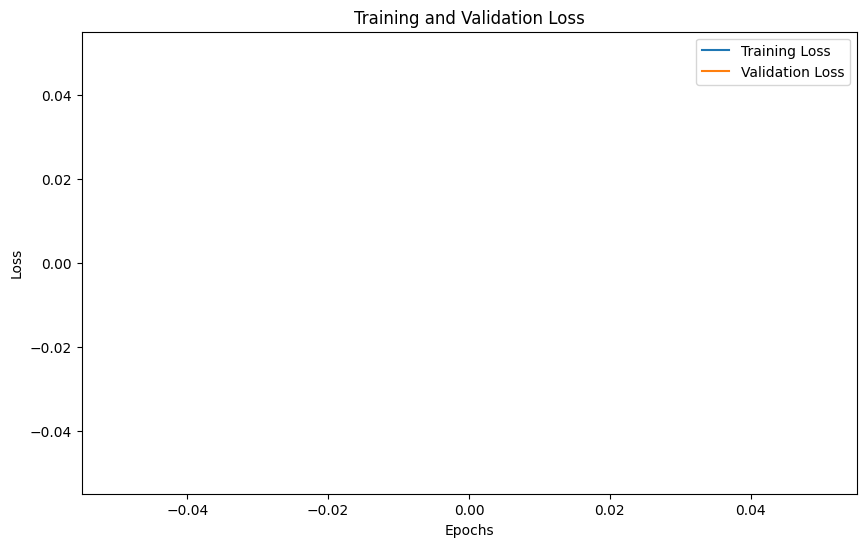

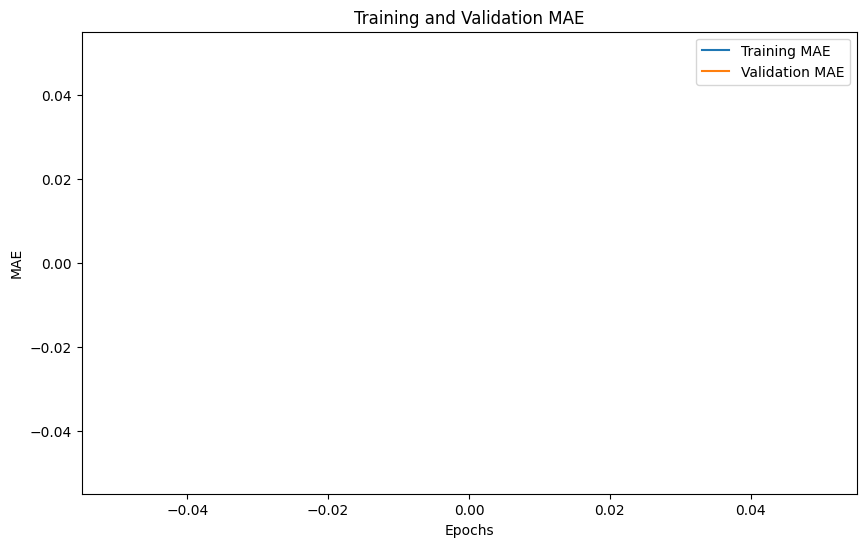

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load Data
# Assume `df` is the DataFrame you've prepared with lagged features
features = [col for col in df.columns if col.startswith('feature')]
target = 'responder_6'

X = df[features].values
y = df[target].values

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the Improved Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),  # Increase dropout to reduce overfitting
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Use Adam optimizer
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae']  # Mean Absolute Error for easier interpretability
)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # Increased epochs for better convergence
    batch_size=64,  # Increase batch size for faster training
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the Model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Save the Model
model.save("improved_mlp_model.h5")

# Visualize Training History
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()